In [69]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import numpy as np
import random
import argparse
from keras.models import model_from_json, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
import tensorflow as tensor
# from keras.engine.training import collect_trainable_weights
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random
import math



from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network import ActorNetwork
from DDPG_Critic_Network import CriticNetwork
from OU import OU
import timeit


iterations = []
error_values = []

OU = OU()

class environment():

    def reset(self):
            self.next_error = random.uniform(1.5,10)
            self.kp = random.randrange(10,100)
            self.ki = random.randrange(10,100)
            self.kd = random.randrange(10,100)
            return self.next_error,self.kp, self.ki, self.kd
        

    def env(self ,a) :
            
            
            self.kp = a[0]
            self.ki = a[1]
            self.kd = a[2]

#             A = 0.00113
#             B = 0.0078854
#             C = 0.0171
#             D = 0.067

#    if self.sys_sel == 1:
#             Jl = 2.5*1e-3
#             Kt = 1
#         elif self.sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
#         elif self.sys_sel == 3:
#             Jl = 2.5*1e-3
#             Kt = 3
#         else:
#             Jl = 0
#             Kt = 0
#             print('\tError! system 1~3 is available for now!')
#             quit()
        # constant
            Jm = 6.329*1e-4
            Tsigma = 1.1*1e-5
            Tsigman = 1.25*1e-4
            B = 3.0*1e-4
            Ksf = (60*1)/(2500*5*1e-3)
            amplitude = 2000
            # sample period: 100us
            T_period = []
            T_ini = 0
            for _ in range(5000):
                T_period.append(T_ini)
                T_ini += 100*1e-6

            '''
            speed loop
            Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
            '''
            A1 = (Jm + Jl) * Tsigman
            A2 = B * Tsigman + (Jm + Jl)
            A3 = B
            B1 = Kt * Ksf
#             self.kp = action[0]
#             self.ki = action[1]
    #         self.kd = action[2]
            # speed loop feedback lti system 
    #         speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            # Angular velocity: Xt
#             speed_fb_lti = scipy.signal.lti([B1*self.kp, B1*self.ki], [A1, A2, A3+B1*self.kp, B1*self.ki])

            feedback_sys = tf([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            
            y, t = step(feedback_sys)
            print("y", y)
            error = 1-y
            absolute_error = np.absolute(error)
            total_error = np.sum(absolute_error)
            itae  = np.sum(absolute_error*t)
            last_error = self.next_error
            self.next_error = total_error
#             reward  = 1/(1 + abs(self.next_error)) - 1/(1 + abs(last_error))
            reward  = math.exp(pow(((0.9 * abs(itae))), 2)/ (-2) * pow(10, 2))
            plt.plot(y,t)
            plt.grid()
            done = False
            if self.next_error < 1:
                done = True
            return total_error, reward, done

PID = environment()

# def play():
    
#     BUFFER_SIZE = 100000
#     BATCH_SIZE = 50
#     GAMMA = 0.99
#     TAU = 0.001     #Target Network HyperParameters
#     LRA = 0.0001    #Learning rate for Actor
#     LRC = 0.001 
#     action_size = 3
#     action_dim = 3
#     state_dim  = 1
#     np.random.seed(1337)
    
#     vision = False
#     EXPLORE = 100000.
#     episode_count = 10000
#     max_steps = 1000
#     reward = 0
#     done = False
#     step = 0
#     epsilon = 1
#     indicator = 0
#     train_indicator = 1
    
#     config = tensor.ConfigProto()
#     config.gpu_options.allow_growth = True
#     sess = tensor.Session(config=config)
#     from keras import backend as K
#     K.set_session(sess)
    
#     actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
#     critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
#     buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
#     for i in range(episode_count):
#         print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
#         total_reward = 0.
#         state,kp,ki,kd = PID.reset()
#         print("reset_error", state)

        
#         for j in range(max_steps):
            
#             loss = 0
#             epsilon  -= 1.0/ EXPLORE
#             a_t = np.zeros([1, action_size])
#             noise_t = np.zeros([1, action_size])
            
#             a_t_original = actor.model.predict(np.array([state]))
# #             print("a_t_original: ", a_t_original)
#             noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0],  2 , 0.01, 0.005)
#             noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1],  2 , 0.01, 0.005)
#             noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.005)
            
#             a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
#             a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
#             a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
# #             print("a_t", a_t[0])
#             next_state, reward, done  = PID.env(a_t[0])
#             print("error",next_state)
#             error_values.append(next_state)
#             buff.add(state, a_t[0], reward, next_state, done)   
#             batch = buff.getBatch(BATCH_SIZE)
#             states = np.asarray([e[0] for e in batch])
#             actions = np.asarray([e[1] for e in batch])
#             rewards = np.asarray([e[2] for e in batch])
#             next_states = np.asarray([e[3] for e in batch])
#             dones = np.asarray([e[4] for e in batch])
#             y_t = np.asarray([e[1] for e in batch])
#             target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
#             for k in range(len(batch)):
#                 if dones[k]:
#                     y_t[k] = rewards[k]
#                 else:
#                     y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
#             if (train_indicator):
#                 loss += critic.model.train_on_batch([(states),actions], y_t) 
# #                 print("loss",loss)
#                 a_for_grad = actor.model.predict(states)
#                 if buff.count() <= BATCH_SIZE:
#                     K= buff.count()
#                 else:
#                     K = BATCH_SIZE
#                 states = states.reshape(K,1)
#                 grads = critic.gradients(states, a_for_grad)

#                 actor.train(states, grads)
#                 actor.target_train()
#                 critic.target_train()
                
            
#             state = next_state
# #             total_reward += reward
# #             print("total_reward", reward)
#             if j == 999:
#                 iterations.append(j)
            
#             if done:
#                 iterations.append(j)
#                 break 
            
                
# if __name__ == "__main__":
#     play()
# warnings.filterwarnings("ignore")








In [ ]:
error = PID.reset()
a = [1,.11,.0001]

error, reward, done = PID.env(a)

In [7]:
a = [8.27e-05, 1.5935e-05,-2.8662e-05]

In [22]:
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random
import math


def env(a) :
            
            
            kp = a[0]
            ki = a[1]
            kd = a[2]

#             A = 0.00113
#             B = 0.0078854
#             C = 0.0171
#             D = 0.067

#    if self.sys_sel == 1:
#             Jl = 2.5*1e-3
#             Kt = 1
#         elif self.sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
#         elif self.sys_sel == 3:
#             Jl = 2.5*1e-3
#             Kt = 3
#         else:
#             Jl = 0
#             Kt = 0
#             print('\tError! system 1~3 is available for now!')
#             quit()
        # constant
            Jm = 6.329*1e-4
            Tsigma = 1.1*1e-5
            Tsigman = 1.25*1e-4
            B = 3.0*1e-4
            Ksf = (60*1)/(2500*5*1e-3)
            amplitude = 2000
            # sample period: 100us
            T_period = []
            T_ini = 0
            for _ in range(5000):
                T_period.append(T_ini)
                T_ini += 100*1e-6

            '''
            speed loop
            Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
            '''
            A1 = (Jm + Jl) * Tsigman
            A2 = B * Tsigman + (Jm + Jl)
            A3 = B
            B1 = Kt * Ksf
#             self.kp = action[0]
#             self.ki = action[1]
    #         self.kd = action[2]
            # speed loop feedback lti system 
    #         speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            # Angular velocity: Xt
#             speed_fb_lti = scipy.signal.lti([B1*self.kp, B1*self.ki], [A1, A2, A3+B1*self.kp, B1*self.ki])

            feedback_sys = tf([B1*kd, B1*kp, B1*ki], [A1, A2+B1*kd, A3+B1*kp, B1*ki])
            
            y, t = step(feedback_sys)
#             print("y", y)
            error = 1-y
            absolute_error = np.absolute(error)
            total_error = np.sum(absolute_error)
            itae  = np.sum(absolute_error*t)
            ise = np.sum(np.square(error))
            itse = np.sum(t*np.square(error))
#             last_error = self.next_error
#             self.next_error = total_error
#             reward  = 1/(1 + abs(self.next_error)) - 1/(1 + abs(last_error))
#             reward  = math.exp(pow(((0.9 * abs(itae))), 2)/ (-2) * pow(10, 2))
            plt.plot(t,y)
            plt.grid()
            plt.show()
#             done = False
#             if self.next_error < 1:
#                 done = True
            return total_error, itae, ise, itse

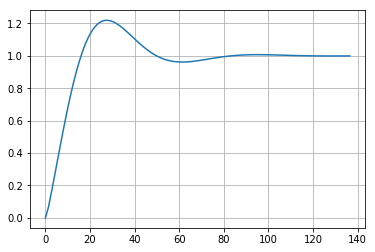

(9.89374817643067, 170.95483463216257, 4.786362830339613, 30.373806380619943)

In [23]:
env(a)

In [ ]:
total_error, itae, ise, itse 9.89374817643067, 170.95483463216257, 4.786362830339613, 30.373806380619943